In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/content/drive/MyDrive/data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]

TRAIN_POSITIONS = ["nondom_hand"]
TEST_POSITIONS  = ["dom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.3
RANDOM_STATE = 42

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [4]:
def load_selected_csvs(base_dir):
    dfs = []
    all_positions = list(set(TRAIN_POSITIONS + TEST_POSITIONS))

    for activity in SELECTED_ACTIVITIES:
        for position in all_positions:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                dfs.append(df)

    print(f"Loaded {len(dfs)} recordings")
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

def build_dataset(dfs, feature_cols):
    X, y, groups = [], [], []

    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue

        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])

    if len(X) == 0:
        return np.array([]), np.array([]), np.array([])

    return np.array(X), np.array(y), np.array(groups)

class MotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.attn(x).squeeze(-1), dim=1)
        return torch.sum(x * weights.unsqueeze(-1), dim=1)

class AttResBiGRU(nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim=128, dropout=0.3):
        super().__init__()

        self.gru = nn.GRU(
            input_size=num_features,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.attention = Attention(hidden_dim * 2)

        self.residual = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(num_features, hidden_dim * 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, num_classes)
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)
        context = self.attention(gru_out)
        res = self.residual(x.permute(0, 2, 1))
        return self.classifier(context + res)

In [6]:
def train_model(X_train, y_train, X_val, y_val, num_classes):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val   = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    train_loader = DataLoader(MotionDataset(X_train, y_train), BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(MotionDataset(X_val, y_val), BATCH_SIZE)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AttResBiGRU(X_train.shape[2], num_classes, dropout=DROPOUT).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)

    best_loss, best_state = np.inf, None

    for _ in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = sum(
            criterion(model(xb.to(device)), yb.to(device)).item() * xb.size(0)
            for xb, yb in val_loader
        ) / len(val_loader.dataset)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model, scaler

def run_cross_position_experiment(all_dfs, feature_cols, title):
    print(f"\n=== {title} ===")

    train_dfs = [df for df in all_dfs if df["phone_position"].iloc[0] in TRAIN_POSITIONS]
    test_dfs  = [df for df in all_dfs if df["phone_position"].iloc[0] in TEST_POSITIONS]

    X_train_full, y_train_full, g_train = build_dataset(train_dfs, feature_cols)
    X_test, y_test, _ = build_dataset(test_dfs, feature_cols)

    le = LabelEncoder()
    le.fit(SELECTED_ACTIVITIES)
    y_train_full = le.transform(y_train_full)
    y_test = le.transform(y_test)

    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    tr_idx, va_idx = next(splitter.split(X_train_full, y_train_full, g_train))

    model, scaler = train_model(
        X_train_full[tr_idx], y_train_full[tr_idx],
        X_train_full[va_idx], y_train_full[va_idx],
        len(le.classes_)
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    loader = DataLoader(MotionDataset(X_test, y_test), BATCH_SIZE)

    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds.extend(model(xb).argmax(1).cpu().numpy())
            trues.extend(yb.numpy())

    print(f"Train Pos: {TRAIN_POSITIONS}")
    print(f"Test Pos:  {TEST_POSITIONS}")
    print(classification_report(trues, preds, target_names=le.classes_, digits=4))

    cm = confusion_matrix(trues, preds)
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cmap="Oranges")
    plt.title(title)
    plt.show()

Loaded 100 recordings

=== Att-Res-BiGRU – Raw ===
Train Pos: ['nondom_hand']
Test Pos:  ['dom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']
              precision    recall  f1-score   support

         run     0.3891    0.1720    0.2386      1000
         sit     0.4527    0.2440    0.3171      1000
      stairs     0.2994    0.6863    0.4169      1020
        walk     0.3267    0.2290    0.2693      1000

    accuracy                         0.3346      4020
   macro avg     0.3670    0.3328    0.3105      4020
weighted avg     0.3666    0.3346    0.3110      4020



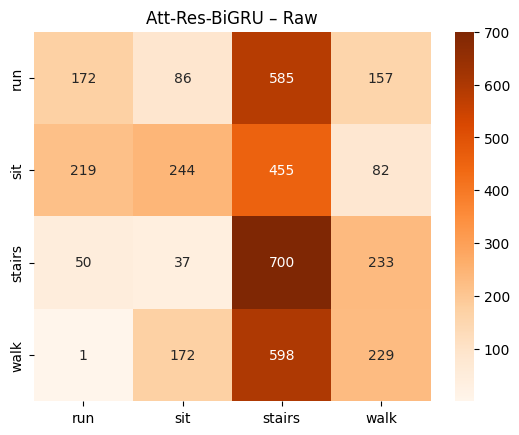


=== Att-Res-BiGRU – GFT ===
Train Pos: ['nondom_hand']
Test Pos:  ['dom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']
              precision    recall  f1-score   support

         run     0.5446    0.0550    0.0999      1000
         sit     0.4273    0.8840    0.5761      1000
      stairs     0.3694    0.1843    0.2459      1020
        walk     0.2998    0.4020    0.3434      1000

    accuracy                         0.3803      4020
   macro avg     0.4102    0.3813    0.3163      4020
weighted avg     0.4100    0.3803    0.3160      4020



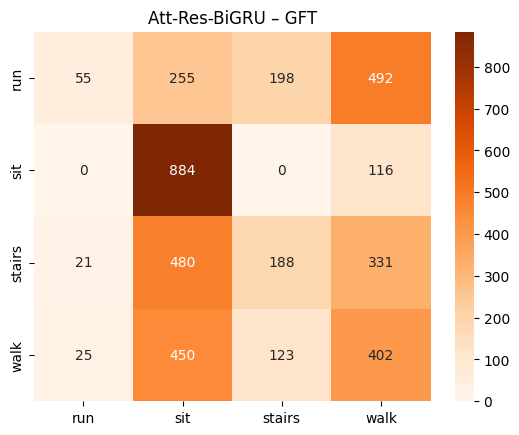

In [11]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)
    run_cross_position_experiment(recordings, RAW_FEATURES, "Att-Res-BiGRU – Raw")
    run_cross_position_experiment(recordings, GFT_FEATURES, "Att-Res-BiGRU – GFT")